In [15]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
from regression_dsets_large_names import regression_dsets_large_names
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data
import fit

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load results from a directory

In [18]:
# depending on how much is saved, this may take a while
# pmlb, gaussian
# rf_gaussian, rf_pmlb (don't sweep rf params, only change n_train)
# rf_gaussian_sweep (only sweep rf params, keep n_train constant)
# rf_pmlb_sweep (sweep rf params, dset - keep n_train constant)
# ridge_gaussian (gaussian dset, sweep ridge param)
# linear_strange_gaussian (gaussian dset, 3 different linear estimators)
# linear_sta (gaussian, pmlb, different noise)
# cov_vary (gaussian, linear, non-iid)
# shifted_test (add ones to the testing covariance matrix, but not the training)
# shifted_test5 (add 5 * ones to the testing cov matrix, but not the training)
out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/double_descent/shifted_test5'
save_dir = 'results'
fnames = sorted([fname for fname in os.listdir(out_dir)])
results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
                if not fname.startswith('weights') and not fname.startswith('idx')]
results = pd.concat(results_list, axis=1).T.infer_objects()

100%|██████████| 90/90 [00:00<00:00, 259.97it/s]


# linear plots

In [19]:
feats = ['dset', 'noise_mult', 'dset_num', 'model_type',
         'n_test', 'test_mse', 'seed', 'preds_test',  'train_mse',
         'n_train', 'n_train_over_num_features', 'num_features', 'ridge_param', 'iid']
feats = feats + ['wnorm', 'H_trace'] # for linear
# feats = feats + ['num_trees', 'max_depth'] # for rf
# feats = feats + ['ridge_param']


r = results
if not 'dset_num' in r:
    r['dset_num'] = r['dset']
r = r[feats]

r2 = r.groupby(['dset', 'noise_mult', 'dset_num', 
                'model_type', 'ridge_param'])
# plt.plot(r.num_features / r.n_train, np.log(r.test_mse), 'o')

# loop over multiple seeds / curves
R, C = 3, 3

for name, gr in r2:
    print('name', name)
    curve = gr.groupby(['n_train'])
    dset = gr.dset.values[0]
    dset_num = gr.dset_num.values[0]
    num_features = gr.num_features.values[0] # assume this was held constant (for each dset)
    model_type = gr.model_type.values[0]
    ridge_param = gr.ridge_param.values[0]
    noise_mult = gr.noise_mult.values[0]
    
    
    # loop over seeds and average / calculate bias stuff
    plt.figure(figsize=(C * 4, R * 4))
    for curve_name, gr2 in tqdm(curve):
        ratio = gr2.num_features.values[0] / gr2.n_train.values[0]        
        preds = gr2.preds_test.values
        preds = np.stack(preds) # num_seeds x n_test
        preds_mean = preds.mean(axis=0).reshape(1, -1) # 1 x n_test
        
        
#                 X_test, y_test, means, covs = data.get_data(p.n_test, p.num_features, 
#                                        noise_mult=p.noise_mult, 
#                                        iid=p.iid, seed=703858704, test=True)
        
        
        if dset == 'gaussian':
            dset_name = ''
            _, y_true, _, _ = data.get_data(gr2.n_test.values[0], num_features, # this assumes that num_features was held constant
                                            noise_mult=0, iid='rand',#gr2.iid.values[0], 
                                            seed=703858704, test=True)
            y_true = y_true.reshape(1, -1) # 1 x n_test
        elif dset == 'pmlb':
            dset_name = regression_dsets_large_names[dset_num]
            X, y = pmlb.fetch_data(dset_name, return_X_y=True)
            fit.seed(703858704)
            _, _, _, y_true = train_test_split(X, y) # get test set
        
        
        bias = np.mean(preds_mean - y_true)
        var = np.mean(np.square(preds - preds_mean))
#         plt.plot(1 / gr2.n_train_over_num_features.mean(), 
#                  gr2.test_mse.mean(), 'o')
        
        if 'linear' in model_type:
            plt.subplot(R, C, 1)
            plt.plot(ratio, bias**2 + var, 'o')
            plt.xlabel('p / n')
            plt.ylabel('test mse')    

            plt.subplot(R, C, 2)
            plt.plot(ratio, bias, 'o')
            plt.xlabel('p / n')
            plt.ylabel('bias')

            plt.subplot(R, C, 3)
            plt.plot(ratio, var, 'o')
            plt.xlabel('p / n')
            plt.ylabel('var')


            plt.subplot(R, C, 4)
            plt.plot(gr2.wnorm.mean(), bias**2 + var, 'o')
            plt.xlabel('$||\hat{w}||_2$')
            plt.ylabel('test mse')

            plt.subplot(R, C, 5)
            plt.plot(gr2.H_trace.mean(), bias**2 + var, 'o')
            plt.xlabel('$tr(H)$')
            plt.ylabel('test mse')     
            
            plt.subplot(R, C, 6)
#             plt.plot(ratio, gr2.wnorm.mean(), 'o')
            plt.plot(ratio, gr2.train_mse.mean(), 'o')
            plt.xlabel('p / n')     
            plt.ylabel('train mse')
#             plt.ylabel('$||\hat{w}||_2$')


            plt.subplot(R, C, 7)
#             plt.plot(ratio, gr2.wnorm.mean(), 'o')
            plt.plot(gr2.train_mse.mean(), gr2.test_mse.mean(), 'o')
            plt.xlabel('train mse')     
            plt.ylabel('test mse')
        else:
            plt.subplot(R, C, 1)
            plt.plot(ratio, bias**2 + var, 'o')
            plt.xlabel('p / n')
            plt.ylabel('test mse')    

            plt.subplot(R, C, 2)
            plt.plot(ratio, bias, 'o')
            plt.xlabel('p / n')
            plt.ylabel('bias')

            plt.subplot(R, C, 3)
            plt.plot(ratio, var, 'o')
            plt.xlabel('p / n')
            plt.ylabel('var')            
    
    for i in range(1, R * C):
        plt.subplot(R, C, i)
        plt.xscale('log')
        plt.yscale('log')
    
    s = f'{model_type}_{dset}_{dset_name}+p={num_features}+ridge={ridge_param}+noise_mult={noise_mult}'
    plt.suptitle(s)
    plt.tight_layout()
    plt.savefig(oj(save_dir, s + '.pdf'))
    plt.close()

  0%|          | 0/15 [00:00<?, ?it/s]

name ('gaussian', 0.1, 1, 'linear', 0)


100%|██████████| 15/15 [01:25<00:00,  5.67s/it]


# rf vary params plots
**here n_train is fixed and we vary only the rf params**

In [28]:
feats = ['dset', 'noise_mult', 'dset_num', 'model_type',
         'n_test', 'test_mse', 'seed', 'preds_test', 
         'n_train', 'n_train_over_num_features', 'num_features']
# feats = feats + ['wnorm', 'H_trace'] # for linear
feats = feats + ['num_trees', 'max_depth'] # for rf
r = results[feats]

r2 = r.groupby(['dset', 'noise_mult', 'dset_num', 'model_type'])
# plt.plot(r.num_features / r.n_train, np.log(r.test_mse), 'o')

# loop over multiple seeds / curves

for name, gr in r2:
    curve = gr.groupby(['num_trees', 'max_depth'])
    dset = gr.dset.values[0]
    dset_num = gr.dset_num.values[0]
    num_features = gr.num_features.values[0] # assume this was held constant (for each dset)
    model_type = gr.model_type.values[0]
    
    
    # loop over seeds and average / calculate bias stuff
    # plt.figure(figsize=(C * 4, R * 4))
    mses, biases, variances = {}, {}, {}
    for curve_name, gr2 in tqdm(curve):
        ratio = gr2.num_features.values[0] / gr2.n_train.values[0]        
        preds = gr2.preds_test.values
        preds = np.stack(preds) # num_seeds x n_test
        preds_mean = preds.mean(axis=0).reshape(1, -1) # 1 x n_test
        
        if dset == 'gaussian':
            dset_name = ''
            _, y_true = data.get_data(gr2.n_test.values[0], num_features, # this assumes that num_features was held constant
                                      noise_mult=0, seed=703858704)
            y_true = y_true.reshape(1, -1) # 1 x n_test
        elif dset == 'pmlb':
            dset_name = regression_dsets_large_names[dset_num]
            X, y = pmlb.fetch_data(dset_name, return_X_y=True)
            fit.seed(703858704)
            _, _, _, y_true = train_test_split(X, y) # get test set
        
        
        bias = np.mean(preds_mean - y_true)
        var = np.mean(np.square(preds - preds_mean))
        mse = bias**2 + var
        
        num_trees = gr2.num_trees.values[0]
        max_depth = gr2.max_depth.values[0]
        mses[(num_trees, max_depth)] = mse
        biases[(num_trees, max_depth)] = bias
        variances[(num_trees, max_depth)] = var

    widths = sorted(list(set(results['num_trees'])))
    depths = sorted(list(set(results['max_depth'])))
    
    mse_arr = np.zeros((len(widths), len(depths)))
    for key in mses:
        width, depth = key
        w_idx = (width==widths).nonzero()[0][0]
        d_idx = (depth==depths).nonzero()[0][0]
        mse_arr[w_idx, d_idx] = mses[key]

    plt.imshow(mse_arr)
    plt.xlabel('max depth')
    plt.ylabel('num trees')
    plt.title('test mse')
    plt.colorbar()
    plt.xticks(range(len(depths)), depths)
    plt.yticks(range(len(widths)), widths)
    
    s = f'heatmap_{model_type}_{dset}_{dset_name}+p={num_features}'
    plt.suptitle(s)
    plt.tight_layout()
    plt.savefig(oj(save_dir, s + '.pdf'))
    plt.close()

100%|██████████| 56/56 [00:10<00:00,  4.77it/s]


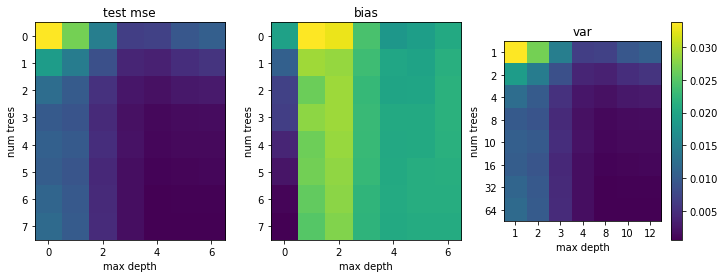

In [31]:
widths = sorted(list(set(results['num_trees'])))
depths = sorted(list(set(results['max_depth'])))
mse_arr = np.zeros((len(widths), len(depths)))
bias_arr = np.zeros((len(widths), len(depths)))
var_arr = np.zeros((len(widths), len(depths)))

for key in mses:
    width, depth = key
    w_idx = (width==widths).nonzero()[0][0]
    d_idx = (depth==depths).nonzero()[0][0]
    mse_arr[w_idx, d_idx] = mses[key]
    bias_arr[w_idx, d_idx] = biases[key]
    var_arr[w_idx, d_idx] = variances[key]
    
R, C = 1, 3 
plt.figure(figsize=(C * 4, R * 4))
plt.subplot(R, C, 1)
plt.imshow(mse_arr)
plt.xlabel('max depth')
plt.ylabel('num trees')
plt.title('test mse')

plt.subplot(R, C, 2)
plt.imshow(bias_arr)
plt.xlabel('max depth')
plt.ylabel('num trees')
plt.title('bias')

plt.subplot(R, C, 3)
plt.imshow(var_arr)
plt.xlabel('max depth')
plt.ylabel('num trees')
plt.title('var')

plt.colorbar()
plt.xticks(range(len(depths)), depths)
plt.yticks(range(len(widths)), widths)
plt.savefig(oj(save_dir, 'rf_gaussian_sweep.pdf'))
# plt.show()
    
# mses